# Risk Analysis

The purpose of this section is to combine the CitiBike trip data with the NYC collision data to perform a risk analysis. The goal is two-fold:
1. Get a measure of risky stations
    - This can be used to warn users about to start their ride from a risky station.
    - Making risk salient may make users extra careful when riding and reduce the accident rate.
2. Create a model capable of predicting the risk associated with a ride from a particular station at a particular time.
    - Such a model is helpful for an insurance company to assess risk when providing ride insurance.
    - In turn, this may be integrated into the pricing strategy, so that the insurance pricing can depend on the station and time.

In [20]:
# Imports
import pandas as pd
import duckdb
from sklearn.neighbors import BallTree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import folium
import branca.colormap as cm


## 1. Risk measure of stations

In [21]:
# Data for station risk measurement
DATA_PATH = "../data/processed/citibike/*/*/data.parquet"

con = duckdb.connect("../data/processed/citibike/citibike.duckdb")

stations = con.execute("""
WITH trips AS (
    SELECT
        start_station_id,
        start_station_name,
        start_lat,
        start_lng,
        end_station_id,
        end_station_name,
        end_lat,
        end_lng
    FROM read_parquet($data_path)
),
stations_union AS (
    SELECT
        start_station_id AS station_id,
        start_station_name AS station_name,
        start_lat AS lat,
        start_lng AS lon
    FROM trips
    WHERE start_station_id IS NOT NULL
      AND start_lat IS NOT NULL
      AND start_lng IS NOT NULL

    UNION

    SELECT
        end_station_id AS station_id,
        end_station_name AS station_name,
        end_lat AS lat,
        end_lng AS lon
    FROM trips
    WHERE end_station_id IS NOT NULL
      AND end_lat IS NOT NULL
      AND end_lng IS NOT NULL
)
SELECT DISTINCT
    station_id,
    station_name,
    ROUND(lat::DOUBLE, 5) AS lat,
    ROUND(lon::DOUBLE, 5) AS lon
FROM stations_union
ORDER BY station_id
""", {"data_path": DATA_PATH}).df()

collision = pd.read_csv("../data/processed/cleaned_collision_data.csv")
collision["CRASH DATETIME"] = pd.to_datetime(collision["CRASH DATETIME"], errors="coerce")

To obtain a station-level indicator of cyclist crash risk, we combine NYPD collision data with CitiBike station locations and trip data. Using a spatial matching approach based on a Haversine-distance BallTree, we assign each crash to its nearest station within a 300-meter radius and compute a severity-weighted risk score for each location. This procedure produces a measure of relative safety across the CitiBike network.

In [22]:
# Combining crash data with nearest stations using BallTree with Haversine distance

# Prepare station coordinate tree (lat/lon → radians)
stations_rad = np.radians(stations[["lat", "lon"]].values)
tree = BallTree(stations_rad, metric="haversine")

# Query nearest station for each crash
crash_coords_rad = np.radians(collision[["LATITUDE", "LONGITUDE"]].values)
dist, idx = tree.query(crash_coords_rad, k=1)

# Convert radians → meters
dist_m = dist * 6371000  

collision["nearest_station_id"] = stations.iloc[idx.flatten()].station_id.values
collision["distance_m"] = dist_m.flatten()

# Filter only crashes within 300m
df_station = collision[collision["distance_m"] <= 300]

# Calculate severity weight as a weighted sum of cyclist involvement, injuries and fatalities
df_station["risk_cyclist"] = (
    1 * df_station["CYCLIST_INVOLVED"] * (1 + 10 * df_station["NUMBER OF PERSONS INJURED"] + 100 * df_station["NUMBER OF PERSONS KILLED"])
)

df_station["risk_non_cyclist"] = (
    (1 - df_station["CYCLIST_INVOLVED"]) * (1 + 10 * df_station["NUMBER OF PERSONS INJURED"] + 100 * df_station["NUMBER OF PERSONS KILLED"])
)

# Aggregate risk per station
risk_raw = (
    df_station.groupby("nearest_station_id")[["risk_cyclist", "risk_non_cyclist"]]
    .sum()
    .reset_index()
)

# Normalize risk to [0, 1]
alpha = 0.10
risk_raw["risk_cyclist_norm"] = risk_raw["risk_cyclist"] / risk_raw["risk_cyclist"].max()
risk_raw["risk_non_cyclist_norm"] = risk_raw["risk_non_cyclist"] / risk_raw["risk_non_cyclist"].max()
risk_raw["risk_norm"] = (1 - alpha) * risk_raw["risk_cyclist_norm"] + alpha * risk_raw["risk_non_cyclist_norm"]
# Merge risk data back to stations
stations_with_risk = stations.merge(risk_raw, how="left", left_on="station_id",
                                    right_on="nearest_station_id")

# Fill NaN risk values with 0
stations_with_risk["risk_cyclist_norm"] = stations_with_risk["risk_cyclist_norm"].fillna(0)
stations_with_risk["risk_non_cyclist_norm"] = stations_with_risk["risk_non_cyclist_norm"].fillna(0)
stations_with_risk["risk_norm"] = stations_with_risk["risk_norm"].fillna(0)

/var/folders/6c/gmnjxh5x1hn48qy93ptqpz580000gn/T/ipykernel_22431/2991747148.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station["risk_cyclist"] = (
/var/folders/6c/gmnjxh5x1hn48qy93ptqpz580000gn/T/ipykernel_22431/2991747148.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station["risk_non_cyclist"] = (


After linking crashes to stations, we translate each incident into a severity score that captures not just the presence of a cyclist but also whether injuries or fatalities occurred. Aggregating these scores at the station level gives a raw measure of crash severity exposure. Because crash events are rare and highly skewed, we normalize these station totals to the [0,1] range to facilitate comparison across the network.

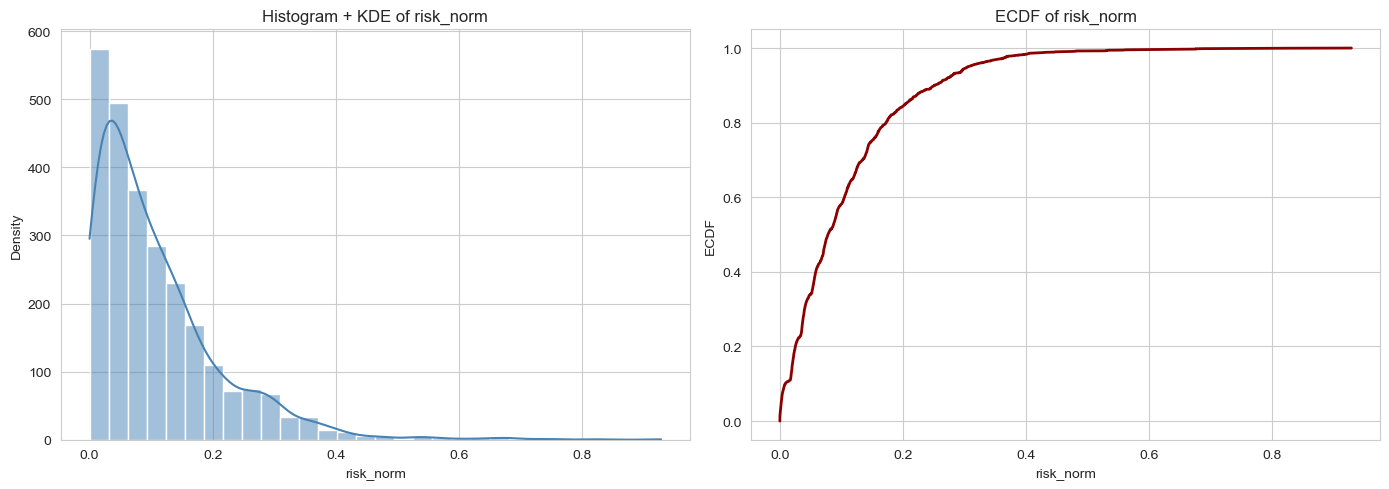

In [23]:
# Visualize the distribution of risk_norm
vals = stations_with_risk["risk_norm"].values


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --------------------------------------------
# LEFT: Histogram + KDE
# --------------------------------------------
sns.histplot(vals, bins=30, kde=True, ax=axes[0], color="steelblue")
axes[0].set_xlabel("risk_norm")
axes[0].set_ylabel("Density")
axes[0].set_title("Histogram + KDE of risk_norm")

# --------------------------------------------
# RIGHT: ECDF
# --------------------------------------------
sorted_vals = np.sort(vals)
ecdf = np.linspace(0, 1, len(sorted_vals))

axes[1].plot(sorted_vals, ecdf, color="darkred", lw=2)
axes[1].set_xlabel("risk_norm")
axes[1].set_ylabel("ECDF")
axes[1].set_title("ECDF of risk_norm")
axes[1].grid(True)

plt.tight_layout()
plt.show()



The resulting distribution of normalized risk scores is heavily right-skewed: most stations experience essentially no cyclist-involved activity, while a small number of stations form a clear upper tail of risk. Plotting both a histogram with a KDE and an empirical CDF reveals that only a small subset of stations contribute meaningfully to the high-risk regions of the city. This suggests that risk is highly localized and that targeted interventions could be more effective than uniform city-wide policies.

In [24]:
risky_threshold = stations_with_risk["risk_norm"].quantile(0.95)
risky = stations_with_risk.loc[stations_with_risk["risk_norm"] >= risky_threshold].copy()

df = risky  # only the filtered stations

center_lat = df["lat"].mean()
center_lon = df["lon"].mean()
fig = folium.Figure(width="60%", height="450px")
m = folium.Map(location=[center_lat, center_lon],
               zoom_start=12,
               tiles="cartodbpositron")
fig.add_child(m)

MAX_RADIUS = 40
colormap = cm.linear.Reds_09.scale(0, 1)

for _, row in df.iterrows():
    radius = max(MAX_RADIUS * row["risk_norm"], 4)
    color = colormap(row["risk_norm"])
    
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=radius,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=folium.Popup(
            f"<b>{row['station_name']}</b><br>"
            f"risk: {row['risk_norm']:.3f}<br>",
            max_width=250,
        ),
    ).add_to(m)

m


Given the strong concentration of risk in the upper tail, it is natural to focus attention on the highest-risk stations. Using the empirical distribution, we select the top 5% of stations by normalized risk and map them using Folium. These stations represent meaningful safety outliers—locations where cyclist-involved crashes with injuries or fatalities disproportionately occur relative to the rest of the network. Visualizing these hotspots helps reveal geographic patterns associated with known high-traffic corridors, bridge access points, or intersections with heavy vehicle flows.

### Conclusion

This station-level risk score provides a practical foundation for a range of safety-oriented applications. CitiBike could integrate this metric into the rider app to warn users who are about to start trips from historically risky stations or to suggest safer nearby alternatives. Operational teams could use the score to identify stations where infrastructure improvements, clearer signage, or temporary mitigations may yield disproportionate safety benefits. Finally, insurers could rely on the risk score to price micro-insurance products, quantify relative exposure, or support data-driven conversations about liability and rider protection.

Overall, this approach offers a transparent, reproducible, and spatially precise way to translate collision data into actionable insights for both riders and system operators.

## 2. Predictive model of risk

To anticipate when and where cyclist crash risk is elevated, we build a predictive model on a station × day × time-of-day panel. Each crash is linked to its nearest station using a Haversine-distance BallTree and assigned a severity-weighted score reflecting cyclist involvement, injuries, and fatalities. Because crashes are rare at the hourly level, we aggregate events into five stable periods of the day (Morning, Midday, Evening, Late Evening, Night). This reduces sparsity and aligns the model with the natural structure of CitiBike usage.

The resulting panel provides, for each station and day–period, a severity-weighted crash outcome that we merge with explanatory variables such as weather, temporal features, and historical risk patterns. The model therefore learns how exposure patterns, traffic conditions, and environmental factors jointly shape cyclist crash risk over time.

This prediction framework forms the first step toward ride-based insurance pricing. Insurers must ultimately estimate expected loss per ride, which requires combining predicted crash intensity at a station–period with the corresponding expected number of rides. By accurately forecasting the underlying risk intensity, the model provides the core input for converting station–period danger levels into actuarially meaningful, time- and location-specific insurance premiums.

### Relevance of the Predictive Risk Model

Even though crashes are rare—appearing in only about one percent of station–day–period observations—the model remains highly relevant because it estimates expected crash severity, not individual crash occurrences. This is standard in insurance and mobility analytics, where rare but high-impact events must be priced based on their underlying risk intensity.

Risk is not uniform across the system: stations differ in traffic volume, road layout, and surrounding conditions, and these differences persist even on days with no crashes. By combining exposure, time-of-day patterns, and historical incidents, the model captures these systematic variations and produces stable relative risk estimates.

These predictions directly support insurance pricing and operational decision-making—allowing CitiBike or an insurer to identify higher-risk stations and assign time- and location-specific expected loss values, despite the sparsity of observed crashes.

In [25]:
df_station["risk_cyclist"] = (
    df_station["CYCLIST_INVOLVED"] * (1 + 10 * df_station["NUMBER OF PERSONS INJURED"]
                                      + 100 * df_station["NUMBER OF PERSONS KILLED"])
)

df_station["risk_non_cyclist"] = (
    (1 - df_station["CYCLIST_INVOLVED"]) * (1 + 10 * df_station["NUMBER OF PERSONS INJURED"]
                                            + 100 * df_station["NUMBER OF PERSONS KILLED"])
)

alpha = 0.10
# later you normalize and blend cyclist + non-cyclist components


/var/folders/6c/gmnjxh5x1hn48qy93ptqpz580000gn/T/ipykernel_22431/960439209.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station["risk_cyclist"] = (
/var/folders/6c/gmnjxh5x1hn48qy93ptqpz580000gn/T/ipykernel_22431/960439209.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_station["risk_non_cyclist"] = (


In [26]:
alpha = 0.10  # same as in your aggregate formula

# After you've computed nearest_station_id and distance_m:
collision_in_radius = collision[collision["distance_m"] <= 300].copy()

# Per-crash components, same as before
collision_in_radius["risk_cyclist"] = (
    collision_in_radius["CYCLIST_INVOLVED"]
    * (1
       + 10 * collision_in_radius["NUMBER OF PERSONS INJURED"]
       + 100 * collision_in_radius["NUMBER OF PERSONS KILLED"])
)

collision_in_radius["risk_non_cyclist"] = (
    (1 - collision_in_radius["CYCLIST_INVOLVED"])
    * (1
       + 10 * collision_in_radius["NUMBER OF PERSONS INJURED"]
       + 100 * collision_in_radius["NUMBER OF PERSONS KILLED"])
)

# Composite per-crash severity, used as target in the panel:
collision_in_radius["severity_weight"] = (
    (1 - alpha) * collision_in_radius["risk_cyclist"]
    + alpha * collision_in_radius["risk_non_cyclist"]
)


In [27]:
# Define period of day mapping
def period_of_day(hour: int) -> str:
    """
    Map hour of day (0-23) to a period label.
    Adjust the cutoffs if you want slightly different buckets.
    """
    if 6 <= hour < 10:
        return "Morning"       # typical AM commute
    elif 10 <= hour < 16:
        return "Midday"
    elif 16 <= hour < 20:
        return "Evening"       # PM commute
    elif 20 <= hour < 24:
        return "Late Evening"
    else:
        return "Night"

# Make sure datetime + period columns exist
collision_in_radius["CRASH DATETIME"] = pd.to_datetime(
    collision_in_radius["CRASH DATETIME"], errors="coerce"
)
collision_in_radius = collision_in_radius.dropna(
    subset=["CRASH DATETIME", "nearest_station_id"]
)

collision_in_radius["date"] = collision_in_radius["CRASH DATETIME"].dt.date
collision_in_radius["period"] = collision_in_radius["CRASH DATETIME"].dt.hour.map(period_of_day)

# Now this works because severity_weight exists:
crash_agg = (
    collision_in_radius
    .groupby(["nearest_station_id", "date", "period"])["severity_weight"]
    .sum()
    .reset_index()
    .rename(
        columns={
            "nearest_station_id": "station_id",
            "severity_weight": "risk_event",  # panel target
        }
    )
)


In [33]:
exposure_query = f"""
WITH trips AS (
    SELECT
        CAST(start_station_id AS VARCHAR) AS start_station_id,
        CAST(end_station_id AS VARCHAR) AS end_station_id,
        CAST(started_at AS TIMESTAMP) AS started_at_ts,
        CAST(ended_at AS TIMESTAMP) AS ended_at_ts
    FROM read_parquet('{DATA_PATH}')
),

labeled AS (
    SELECT
        start_station_id AS station_id,
        date_trunc('day', started_at_ts) AS date,
        CASE
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 6 AND 9 THEN 'Morning'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 10 AND 15 THEN 'Midday'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 16 AND 19 THEN 'Evening'
            WHEN EXTRACT(HOUR FROM started_at_ts) BETWEEN 20 AND 23 THEN 'Late Evening'
            ELSE 'Night'
        END AS period,
        1 AS departure,
        0 AS arrival
    FROM trips
    WHERE start_station_id IS NOT NULL

    UNION ALL

    SELECT
        end_station_id AS station_id,
        date_trunc('day', ended_at_ts) AS date,
        CASE
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 6 AND 9 THEN 'Morning'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 10 AND 15 THEN 'Midday'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 16 AND 19 THEN 'Evening'
            WHEN EXTRACT(HOUR FROM ended_at_ts) BETWEEN 20 AND 23 THEN 'Late Evening'
            ELSE 'Night'
        END AS period,
        0 AS departure,
        1 AS arrival
    FROM trips
    WHERE end_station_id IS NOT NULL
)

SELECT
    station_id,
    date,
    period,
    SUM(departure) AS departures_period,
    SUM(arrival) AS arrivals_period,
    SUM(departure + arrival) AS rides_period
FROM labeled
GROUP BY station_id, date, period
ORDER BY station_id, date, period
"""
exposure_agg = con.execute(exposure_query).df()

In [34]:
exposure_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9360533 entries, 0 to 9360532
Data columns (total 6 columns):
 #   Column             Dtype         
---  ------             -----         
 0   station_id         object        
 1   date               datetime64[us]
 2   period             object        
 3   departures_period  float64       
 4   arrivals_period    float64       
 5   rides_period       float64       
dtypes: datetime64[us](1), float64(3), object(2)
memory usage: 428.5+ MB


In [39]:
import pandas as pd
import numpy as np

###############################################################################
# 1. Create target variable: station × day × period crash severity (risk_event)
###############################################################################

# Ensure datetime
collision_in_radius["CRASH DATETIME"] = pd.to_datetime(
    collision_in_radius["CRASH DATETIME"], errors="coerce"
)

# Convert station_id to string
collision_in_radius["nearest_station_id"] = collision_in_radius["nearest_station_id"].astype(str)

# Date + period
collision_in_radius["date"] = collision_in_radius["CRASH DATETIME"].dt.floor("D")
collision_in_radius["period"] = collision_in_radius["CRASH DATETIME"].dt.hour.map(period_of_day)

# Aggregate
crash_agg = (
    collision_in_radius.groupby(["nearest_station_id", "date", "period"])["severity_weight"]
    .sum()
    .reset_index()
    .rename(columns={
        "nearest_station_id": "station_id",
        "severity_weight": "risk_event"
    })
)

###############################################################################
# 2. Build the full station × day × period panel backbone
###############################################################################

# union of station IDs present in exposure or crashes
station_ids = np.union1d(exposure_agg["station_id"].unique(), crash_agg["station_id"].unique())

# date range from exposure and crashes
min_date = min(exposure_agg["date"].min(), crash_agg["date"].min())
max_date = max(exposure_agg["date"].max(), crash_agg["date"].max())
dates = pd.date_range(min_date, max_date, freq="D")
periods = ["Night", "Morning", "Midday", "Evening", "Late Evening"]

# Construct panel
panel_index = pd.MultiIndex.from_product(
    [station_ids, dates, periods],
    names=["station_id", "date", "period"]
)

panel = pd.DataFrame(index=panel_index).reset_index()

###############################################################################
# 3. Merge exposure + risk target
###############################################################################

panel = panel.merge(exposure_agg, on=["station_id", "date", "period"], how="left")
panel = panel.merge(crash_agg, on=["station_id", "date", "period"], how="left")

# Replace missing exposures with 0
panel[["departures_period", "arrivals_period", "rides_period"]] = (
    panel[["departures_period", "arrivals_period", "rides_period"]].fillna(0)
)

# Replace missing target with 0
panel["risk_event"] = panel["risk_event"].fillna(0)

###############################################################################
# 4. Calendar features
###############################################################################

panel["weekday"] = panel["date"].dt.weekday
panel["is_weekend"] = panel["weekday"].isin([5, 6]).astype(int)
panel["month"] = panel["date"].dt.month

# Placeholder holiday flag (you can replace later)
panel["is_holiday"] = 0

# 5. Historical risk features
panel = panel.sort_values(["station_id", "period", "date"])

panel["past_7d_risk"] = (
    panel.groupby(["station_id", "period"])["risk_event"]
         .transform(lambda s: s.shift(1).rolling(7, min_periods=1).sum())
)

panel["past_30d_risk"] = (
    panel.groupby(["station_id", "period"])["risk_event"]
         .transform(lambda s: s.shift(1).rolling(30, min_periods=1).sum())
)

panel["past_7d_risk"] = panel["past_7d_risk"].fillna(0)
panel["past_30d_risk"] = panel["past_30d_risk"].fillna(0)

# 6. Exposure rolling feature
panel["rides_period_7d_mean"] = (
    panel.groupby(["station_id", "period"])["rides_period"]
         .transform(lambda s: s.shift(1).rolling(7, min_periods=1).mean())
)

panel["rides_period_7d_mean"] = panel["rides_period_7d_mean"].fillna(0)
###############################################################################
# 7. Done — your modeling dataset is ready
###############################################################################

print(panel.head())
print("Final panel shape:", panel.shape)

   station_id       date   period  departures_period  arrivals_period  \
3     1234.56 2022-12-28  Evening                0.0              0.0   
8     1234.56 2022-12-29  Evening                0.0              0.0   
13    1234.56 2022-12-30  Evening                0.0              0.0   
18    1234.56 2022-12-31  Evening                0.0              0.0   
23    1234.56 2023-01-01  Evening                0.0              0.0   

    rides_period  risk_event  weekday  is_weekend  month  is_holiday  \
3            0.0         0.0        2           0     12           0   
8            0.0         0.0        3           0     12           0   
13           0.0         0.0        4           0     12           0   
18           0.0         0.0        5           1     12           0   
23           0.0         0.0        6           1      1           0   

    past_7d_risk  past_30d_risk  rides_period_7d_mean  
3            0.0            0.0                   0.0  
8            0.0

In [40]:
panel["risk_event"].describe()

count    1.196928e+07
mean     1.695838e-02
std      4.119584e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.269000e+02
Name: risk_event, dtype: float64

In [43]:
len(panel[panel["risk_event"] > 0])/len(panel)

0.01047423069725163

In [42]:
len(panel)

11969280